<a href="https://colab.research.google.com/github/lixinso/sample-intro-to-pytorch/blob/master/sample_pytorch_customized_data_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [0]:
import warnings
warnings.filterwarnings("ignore")

plt.ion() #interactive mode

In [4]:
#Download data
'''
!mkdir -p data
!ls data
!wget https://download.pytorch.org/tutorial/faces.zip 

!unzip faces.zip
!mv faces data/faces
!ls 
!rm -f faces.zip
'''

'\n!mkdir -p data\n!ls data\n!wget https://download.pytorch.org/tutorial/faces.zip \n\n!unzip faces.zip\n!mv faces data/faces\n!ls \n!rm -f faces.zip\n'

In [5]:
!ls data/faces

0805personali01.jpg	   3298715079_5af7c78fcb.jpg
1084239450_e76e00b7e7.jpg  3325611505_ddc7beffa1.jpg
10comm-decarlo.jpg	   3362762930_24f76cb89c.jpg
110276240_bec305da91.jpg   343583208_e986824d77.jpg
1198_0_861.jpg		   3461016494_56cce9c984.jpg
137341995_e7c48e9a75.jpg   348272697_832ce65324.jpg
1383023626_8a49e4879a.jpg  3534188114_2108895291.jpg
144044282_87cf3ff76e.jpg   3534189272_8ef88ba368.jpg
152601997_ec6429a43c.jpg   3555944509_7b477069c6.jpg
1549040388_b99e9fa295.jpg  3574737496_6ee8207045.jpg
1878519279_f905d4f34e.jpg  362167809_d5a5dcbfdb.jpg
2046713398_91aaa6fe1c.jpg  363149951_8be04dc6c0.jpg
2173711035_dbd53b4f9f.jpg  3638950581_3387685d3a.jpg
2210514040_6b03ff2629.jpg  3646828311_bfeb429ef7.jpg
2322901504_08122b01ba.jpg  3689162471_5f9ffb5aa0.jpg
2327253037_66a61ea6fe.jpg  3718903026_c1bf5dfcf8.jpg
2328398005_d328a70b4c.jpg  3790616528_297c0ac935.jpg
2370961440_6bc8ce346c.jpg  3855944735_e252959937.jpg
2382SJ8.jpg		   3856149136_d4595ffdd4.jpg
252418361_440b75751b.jpg 

In [0]:
landmarks_frame = pd.read_csv("data/faces/face_landmarks.csv")

In [7]:
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,139,49,150,60,159,73,166,87,168,100,166,111,160,120,151,128,141,133,128,137,116,138,102,138,89,44,70,53,66,63,...,71,137,78,131,85,127,90,129,94,129,99,134,103,142,97,144,92,145,88,145,83,144,77,141,75,137,85,134,89,135,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,320,100,340,111,359,126,375,149,379,175,376,197,364,218,346,236,322,249,296,254,266,256,237,256,207,65,210,69,197,80,...,110,314,117,310,126,308,135,309,147,307,164,306,184,307,167,317,152,321,139,323,130,322,120,318,114,313,127,312,136,313,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,169,80,180,91,189,103,195,115,197,128,197,139,192,148,184,154,173,160,162,164,150,169,138,171,126,80,101,87,95,98,...,101,163,109,157,117,155,123,157,129,156,134,160,139,168,133,171,126,172,120,172,114,171,107,168,104,162,116,161,122,162,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,220,89,238,108,255,129,268,155,268,180,261,203,244,222,224,238,199,247,172,248,144,245,116,241,87,39,114,45,102,57,...,98,207,107,199,120,193,131,193,142,188,162,185,184,187,168,206,151,218,139,222,127,223,113,219,103,206,122,203,133,201,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,536,186,567,214,594,249,614,290,616,329,608,363,589,390,562,411,529,421,491,425,450,425,409,423,370,162,345,178,330,200,...,228,514,246,502,264,495,278,499,292,495,315,502,341,511,318,530,297,538,281,539,266,537,248,529,239,513,265,507,278,509,293,507,331,511,294,516,279,518,265,516


In [8]:
landmarks_frame.describe()

,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,part_19_y,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,108.289855,151.101449,108.913043,174.260870,111.521739,197.449275,116.739130,220.188406,126.130435,241.014493,139.956522,259.304348,156.304348,274.565217,174.855072,286.188406,195.637681,289.333333,216.159420,285.637681,234.550725,273.855072,250.942029,258.739130,264.449275,240.478261,273.739130,219.434783,278.695652,196.695652,281.043478,173.275362,281.405797,149.927536,124.536232,133.739130,135.014493,123.434783,150.217391,120.057971,...,161.913043,230.927536,173.637681,225.507246,185.826087,222.768116,194.478261,225.043478,203.246377,222.753623,215.739130,225.492754,228.217391,230.666667,216.304348,242.376812,204.333333,247.898551,194.840580,248.826087,185.434783,247.797101,173.652174,242.333333,167.043478,231.347826,185.782609,230.043478,194.536232,231.028986,203.347826,230.101449,223.144928,231.246377,203.782609,236.681159,194.768116,237.811594,185.884058,236.463768
std,69.881854,62.507210,69.022106,64.967787,68.261954,68.970483,67.423737,73.715924,66.070131,78.498875,64.978149,82.886582,64.645255,86.843246,65.144923,89.675932,66.983749,89.986219,69.380796,88.148766,72.138049,84.053428,75.286098,79.095001,78.866704,73.898302,81.482523,68.672599,82.709859,64.073328,83.027712,61.113656,83.137434,60.238574,66.961047,58.278654,66.323515,57.316069,65.667135,57.041235,...,63.543579,73.434308,63.783635,71.100927,64.521532,70.110448,65.197124,70.528558,65.936780,69.856240,67.440748,70.578205,69.418143,72.252146,67.918702,75.890033,66.635900,78.195484,65.657898,78.699158,64.915664,78.527923,64.056461,76.666517,63.600184,73.265999,64.616941,71.808658,65.290207,71.940329,66.086135,71.462072,68.569260,72.309467,66.235735,74.600208,65.354946,75.183750,64.607761,74.859983
min,-8.000000,48.000000,-6.000000,76.000000,-10.000000,86.000000,-8.000000,97.000000,6.000000,107.000000,26.000000,116.000000,49.000000,122.000000,61.000000,126.000000,72.000000,127.000000,83.000000,126.000000,95.000000,123.000000,106.000000,119.000000,113.000000,111.000000,117.000000,101.000000,119.000000,91.000000,121.000000,73.000000,122.000000,35.000000,10.000000,39.000000,23.000000,23.000000,39.000000,19.000000,...,55.000000,98.000000,61.000000,96.000000,65.000000,94.000000,68.000000,95.000000,71.000000,94.000000,78.000000,95.000000,88.000000,99.000000,80.000000,103.000000,73.000000,105.000000,69.000000,105.000000,66.000000,105.000000,62.000000,103.000000,58.000000,99.000000,65.000000,98.000000

In [9]:
n = 65
img_name = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n,1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1,2)

print("Image name: {}".format(img_name))
print("Landmarks shape: {}".format(landmarks.shape))
print("First 4 Landmarks: {}".format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [10]:
def show_landmarks(image, landmarks):
  plt.imshow(image)
  plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='r')
  plt.pause(0.001) #pause a bit so that plots are updated

'''

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
'''

"\n\nplt.figure()\nshow_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)\n"


## Dataset



In [0]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype("float").reshape(-1,2)
        sample = {'image': image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
            
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        print(landmarks.shape, new_w, w, new_h, h)

        landmarks = landmarks * [new_w / w, new_h / h]

        return {"image": img, "landmarks": landmarks}

In [0]:
class RandomCrop(object):

    def __init__(self, output_size):

        assert isinstance(output_size, (int, tuple))

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)

        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        image, landmarks = sample["image"], sample["landmarks"]

        h, w = image.shape[:2]

        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        landmarks = landmarks - [left, top]

        return {"image": image, "landmarks": landmarks}

In [0]:
class ToTensor(object):

    def __call__(self, sample):

        image, landmarks = sample["image"], sample["landmarks"]

        image = image.transpose((2,0,1))

        return {"image": torch.from_numpy(image), "landmarks": torch.from_numpy(landmarks)}

In [16]:
face_dataset = FaceLandmarksDataset(csv_file="data/faces/face_landmarks.csv", root_dir="data/faces/",
                                    transform = transforms.Compose([Rescale(256),
                                                                    RandomCrop(224),
                                                                    ToTensor()
                                    ]))

'''
fig = plt.figure()

for i in range(len(face_dataset)):
  sample = face_dataset[i]

  print(i, sample['image'].shape, sample['landmarks'].shape)

  ax = plt.subplot(1,4, i + 1)
  plt.tight_layout()
  ax.set_title("Sample #{}".format(i))
  ax.axis("off")
  show_landmarks(**sample)

  if i == 3:
    plt.show()
    break
'''

'\nfig = plt.figure()\n\nfor i in range(len(face_dataset)):\n  sample = face_dataset[i]\n\n  print(i, sample[\'image\'].shape, sample[\'landmarks\'].shape)\n\n  ax = plt.subplot(1,4, i + 1)\n  plt.tight_layout()\n  ax.set_title("Sample #{}".format(i))\n  ax.axis("off")\n  show_landmarks(**sample)\n\n  if i == 3:\n    plt.show()\n    break\n'

## Batch

In [0]:
dataloader = DataLoader(face_dataset, batch_size=4, shuffle=True, num_workers=4)

(68, 2) 256 160 256 160
(68, 2) 256 333 384 500
(68, 2) 320 500 256 400
(68, 2) 384 500 256 333
(68, 2) 256 333 384 500
(68, 2) 385 500 256 332
(68, 2) 256 375 341 500
(68, 2) 341 500 256 375
(68, 2) 256 375 341 500
(68, 2) 264 258 256 250
(68, 2) 318 500 256 402
(68, 2) 256 335 382 500
(68, 2) 384 500 256 333
(68, 2) 256 333 384 500
(68, 2) 256 334 383 500
(68, 2) 256 340 282 375
(68, 2) 256 209 292 239
(68, 2) 256 326 392 500
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
(68, 2) 384 500 256 333
(68, 2) 384 500 256 333
(68, 2) 384 500 256 333
(68, 2) 256 240 341 320
(68, 2) 256 333 384 500
(68, 2) 256 333 384 500
(68, 2) 384 500 256 333
(68, 2) 384 500 256 333
(68, 2) 256 334 383 500
(68, 2) 384 500 256 333
(68, 2) 256 342 374 500
(68, 2) 256 375 341 500
(68, 2) 256 333 384 500
(68, 2) 256 169 389 257
(68, 2) 385 480 

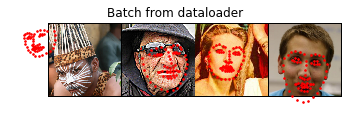

(68, 2) 256 333 384 500
(68, 2) 256 375 341 500
(68, 2) 384 500 256 333
(68, 2) 256 175 365 250
(68, 2) 341 500 256 375
(68, 2) 256 335 382 500
(68, 2) 384 500 256 333
(68, 2) 256 630 336 828
(68, 2) 256 500 256 500
(68, 2) 384 500 256 333


In [19]:
def show_landmarks_batch(sample_batched):
  images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  grid_border_size = 2

  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1,2,0)))

  for i in range(batch_size):
    plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size, 
                landmarks_batch[i, :, 1].numpy() + grid_border_size, 
                s = 10, 
                marker = '.',
                c = 'r')
    
    plt.title("Batch from dataloader")


for i_batch, sample_batched in enumerate(dataloader):
  print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())

  if i_batch == 3:
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break